<a href="https://colab.research.google.com/github/pankajti/wqu/blob/main/DL/Copy_of_GWP1_3941_pankaj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 Time Series Selection and Analysis

In [ ]:
!pip install pyts
from IPython.display import clear_output
clear_output()

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import gc
import os
import random
import copy
import statsmodels
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import plotly.graph_objects as go
import sklearn
from pyts.image import GramianAngularField



### a. Choosing data set and Test For Stationarity
We choose a symbol and download daily data from yahoo finance. We pick close price for our analysis



In [ ]:
ticker_name = 'GOOG'
ticker = yf.Ticker(ticker_name)

In [ ]:
data = ticker.history(interval='1d', start='2016-01-01')

In [ ]:
close = data['Close']

In [ ]:
ret = close.pct_change()

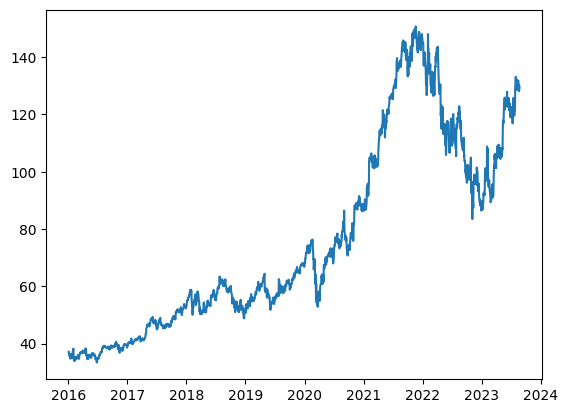

In [ ]:
plt.plot(close)

In [ ]:
close.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1922 entries, 2016-01-04 00:00:00-05:00 to 2023-08-22 00:00:00-04:00
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1922 non-null   float64
dtypes: float64(1)
memory usage: 30.0 KB


In [ ]:
close.describe()

count    1922.000000
mean       76.422008
std        33.722286
min        33.412998
25%        50.972251
50%        62.080250
75%       104.730249
max       150.709000
Name: Close, dtype: float64

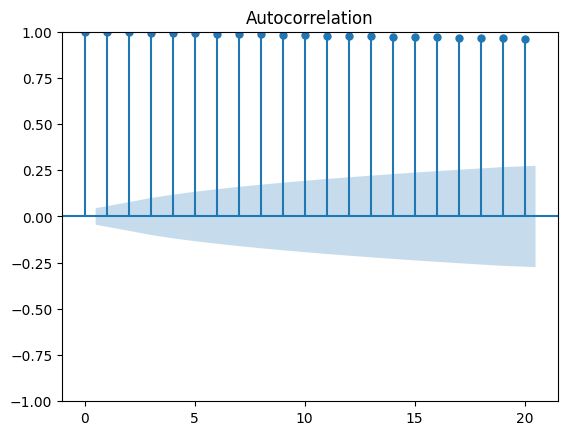

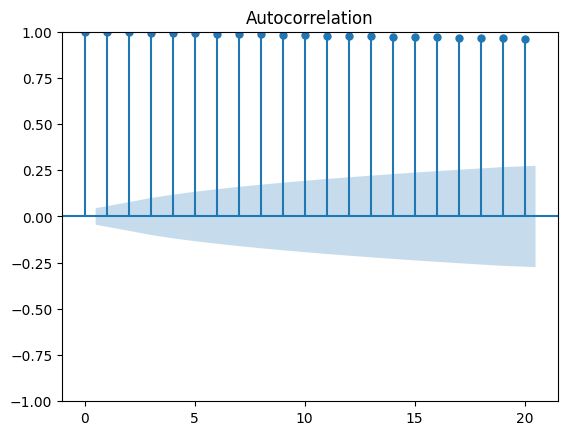

In [ ]:
plot_acf(close, lags =20)


Graph of the time series and autocorrelation diagram shows that the time series is not stationary.
next we perform ADF test for checking stationarity

In [ ]:
adftest=adfuller(close)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -0.463561
ADF p-value: 0.898933


ADF has high p value of 0.9 which makes us fail to reject the null hypothesis that the time series is not stationary.
Lets transform the series by taking diff and run ADF test

### b. Test for stationarily and visualization of Transformed Data

In [ ]:
# log_close = np.log(close)
# adftest=adfuller(log_close)
# print('ADF Statistic: %f' % adftest[0])
# print('ADF p-value: %f' % adftest[1])

In [ ]:
diff_return=close-close.shift(1)


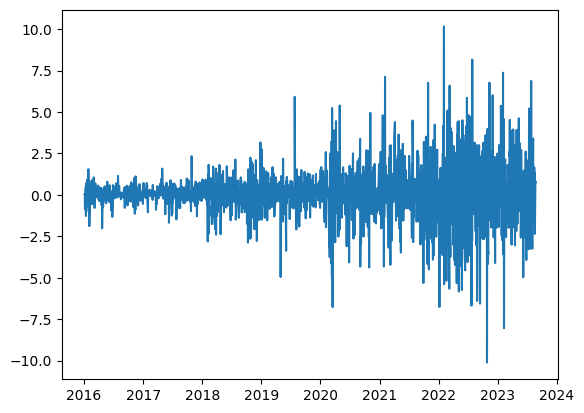

In [ ]:
plt.plot(diff_return)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


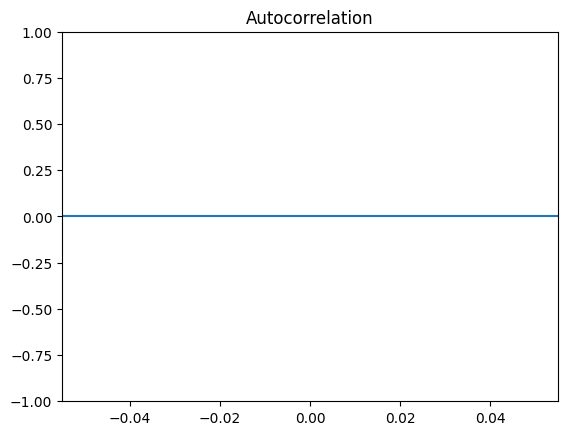

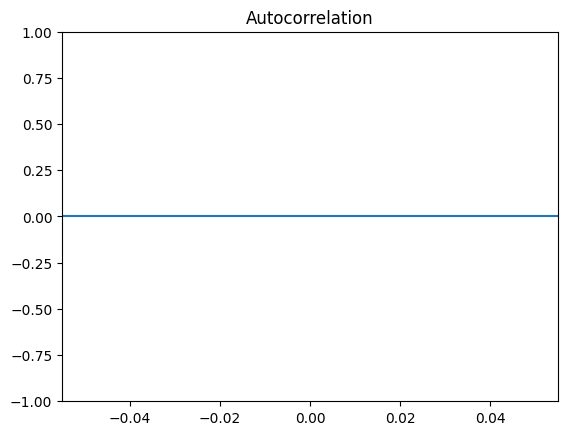

In [ ]:
plot_acf(diff_return, lags =20)


In [ ]:
adftest=adfuller(diff_return.dropna())
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])


ADF Statistic: -10.684836
ADF p-value: 0.000000


Taking a difference makes the time series stationary as we can see from the plot and ADF test. But here the p value is too low which means any memory info of the time series is completely gone by the difference.
Next we 'll use partial differencing to subtract just the fraction which is enough for making TS stationary and still keeping the some memory component.

In [ ]:
# diff_return_log=np.log(close)-np.log(close).shift(1)
# adftest=adfuller(diff_return_log.dropna())
# print('ADF Statistic: %f' % adftest[0])
# print('ADF p-value: %f' % adftest[1])

### Fractional Differenctiating and Test For Stationarity

We can transform partially using following formula and obtain and a new TS which is stationary by choosing appropriate value of d.

$
X_t = (1-B)^d(X_t)
$

In [ ]:
def getWeights(d, lags):
  w=[1]
  for k in range(1,lags):
    w.append(-w[-1]*((d-k+1))/k)
  w=np.array(w).reshape(-1,1)
  return w

In [ ]:
getWeights(4,10)

array([[ 1.],
       [-4.],
       [ 6.],
       [-4.],
       [ 1.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.]])

In [ ]:
def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients

    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [ ]:
ts_differencing(close, 1, 20)

Date
2016-02-02 00:00:00-05:00    0.632500
2016-02-03 00:00:00-05:00   -1.884998
2016-02-04 00:00:00-05:00   -0.946999
2016-02-05 00:00:00-05:00   -1.222000
2016-02-08 00:00:00-05:00   -0.041500
                               ...   
2023-08-16 00:00:00-04:00   -1.160004
2023-08-17 00:00:00-04:00    1.350006
2023-08-18 00:00:00-04:00   -2.350006
2023-08-21 00:00:00-04:00    0.819992
2023-08-22 00:00:00-04:00    0.760010
Name: Close, Length: 1902, dtype: float64

In [ ]:
frac_diff_return=ts_differencing(close, .5, 200)


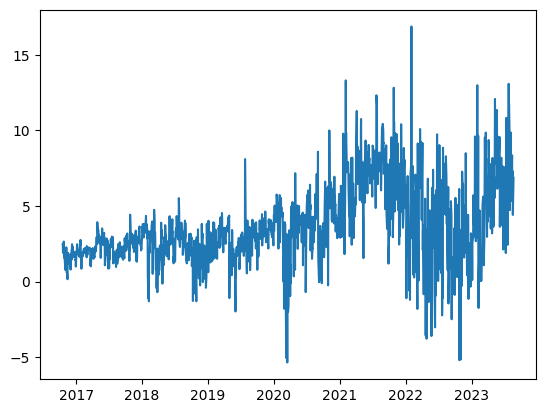

In [ ]:
plt.plot(frac_diff_return)

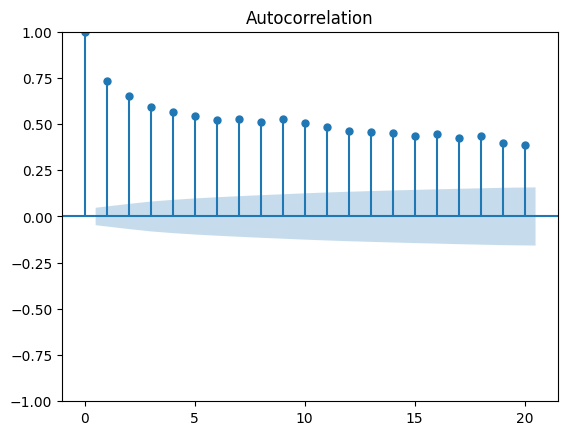

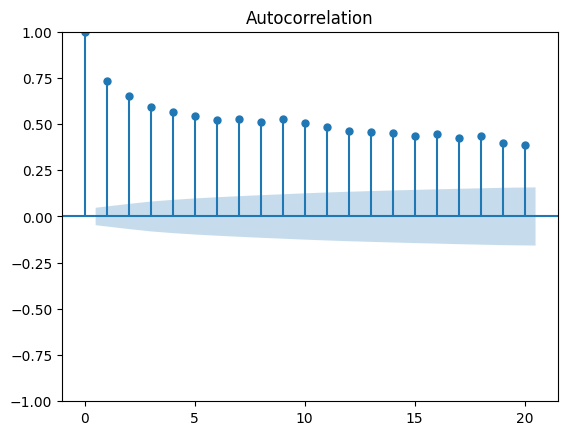

In [ ]:
plot_acf(frac_diff_return, lags =20)


In [ ]:
adftest=adfuller(frac_diff_return.dropna())
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -3.256629
ADF p-value: 0.016932


In [ ]:
df = data[:100]

In [ ]:
# close
# diff_return
# frac_diff_return

## Step 2 MLP Design

### a. Design MLP using Original TS

In [ ]:
def get_data(time_series):
  ts_data = pd.DataFrame()
  lags = 30
  ts_data['t']=time_series
  for l in range(1,lags+1) :
    ts_data[f't_{l}'] = time_series.shift(l)

  X= ts_data.iloc[:,1:]
  y=ts_data['t_1']>ts_data[f't_{lags}']
  X=X[lags:]
  y=y[lags:]
  return X,y

In [ ]:
X, y = get_data(close)

In [ ]:
#print(X.head())
#print(y.head())


                                  t
Date                               
2016-11-30 00:00:00-05:00  1.010985
2016-12-01 00:00:00-05:00  0.795711
2016-12-02 00:00:00-05:00  1.242624
2016-12-05 00:00:00-05:00  1.873110
2016-12-06 00:00:00-05:00  1.436286


In [ ]:
def get_mlp_model():
  model = Sequential()
  model.add(Dense(100, activation ='relu'))
  model.add(Dense(1,activation = 'linear', name='output'))
  return model

model = get_mlp_model()
model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= ['accuracy'] )
model.fit(X,y, batch_size =8, epochs =10)




Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


237/237 [==============================] - 1s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 2/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 3/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 4/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 5/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 6/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 7/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 8/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 9/10
237/237 [==============================] - 0s 2ms/step - loss: 7.5230e-08 - accuracy: 0.3689
Epoch 10/10
237/237 [==============================] - 0s 2ms/step - loss: 

### b. MLP using stationary version of TS

In [ ]:
X, y = get_data(diff_return)


In [ ]:
model = get_mlp_model()
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])
model.fit(X[1:],y[1:], batch_size =8, epochs =10)

Epoch 1/10
237/237 [==============================] - 1s 2ms/step - loss: 0.3844 - mae: 0.4949
Epoch 2/10
237/237 [==============================] - 0s 2ms/step - loss: 0.2172 - mae: 0.3941
Epoch 3/10
237/237 [==============================] - 0s 2ms/step - loss: 0.1666 - mae: 0.3486
Epoch 4/10
237/237 [==============================] - 1s 3ms/step - loss: 0.1409 - mae: 0.3247
Epoch 5/10
237/237 [==============================] - 1s 2ms/step - loss: 0.1253 - mae: 0.3068
Epoch 6/10
237/237 [==============================] - 1s 2ms/step - loss: 0.1158 - mae: 0.2934
Epoch 7/10
237/237 [==============================] - 1s 2ms/step - loss: 0.1073 - mae: 0.2832
Epoch 8/10
237/237 [==============================] - 1s 2ms/step - loss: 0.1004 - mae: 0.2720
Epoch 9/10
237/237 [==============================] - 0s 2ms/step - loss: 0.0968 - mae: 0.2675
Epoch 10/10
237/237 [==============================] - 0s 2ms/step - loss: 0.0903 - mae: 0.2567


### c. MLP using Fractional Diffferencing version of TS





In [ ]:
X, y = get_data(frac_diff_return)


In [ ]:
model = get_mlp_model()
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])
model.fit(X,y, batch_size =8, epochs =10)

Epoch 1/10
212/212 [==============================] - 1s 2ms/step - loss: 0.8253 - mae: 0.6914
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 0.3847 - mae: 0.4984
Epoch 3/10
212/212 [==============================] - 0s 2ms/step - loss: 0.3135 - mae: 0.4529
Epoch 4/10
212/212 [==============================] - 0s 2ms/step - loss: 0.2648 - mae: 0.4157
Epoch 5/10
212/212 [==============================] - 0s 2ms/step - loss: 0.2327 - mae: 0.3943
Epoch 6/10
212/212 [==============================] - 0s 2ms/step - loss: 0.2297 - mae: 0.3903
Epoch 7/10
212/212 [==============================] - 0s 2ms/step - loss: 0.2156 - mae: 0.3775
Epoch 8/10
212/212 [==============================] - 0s 2ms/step - loss: 0.2004 - mae: 0.3659
Epoch 9/10
212/212 [==============================] - 0s 2ms/step - loss: 0.1885 - mae: 0.3539
Epoch 10/10
212/212 [==============================] - 0s 2ms/step - loss: 0.1767 - mae: 0.3505


### d. Evaluating MLP models with different datasets

Original data seems to perform better. We further need to check performance on test data and use some hyperparameter optimization techniques to fine tune models.

## Step 3 CNN Design

### a. Design CNN using Original TS data

In [ ]:
# X_data = []
# window_size = 30
# for i in range(window_size, Xdf.shape[0]):
#     X_data.append(Xdf[i - window_size : i])
# X_data = np.array(X_data)
# print(X_data.shape)
# # Define a "window_size"-days interval
# days = np.linspace(1, X_data.shape[0], num=X_data.shape[0])
# # Plot the overlapping time series
# plt.figure(figsize=(6, 6))
# for i in range(241):
#     plt.plot(days[i : window_size + i], X_data[i, :])
# transformer = GramianAngularField()
# X_data_new = transformer.transform(X_data)
# print(X_data_new.shape)

In [ ]:
def get_transofromed_images_labels(time_series ,window_size = 30):
  X_data = []
  for i in range(window_size, time_series.shape[0]):
      X_data.append(time_series[i - window_size : i])
  X_data = np.array(X_data)
  transformer = GramianAngularField()
  X_data_new = transformer.transform(X_data)
  y_data = []
  for i in range(0, time_series.shape[0] - window_size):
      y_data.append(time_series[i] < time_series[i + window_size])
  y_data = np.array(y_data)
  return X_data, X_data_new , y_data,

In [ ]:
orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(close)

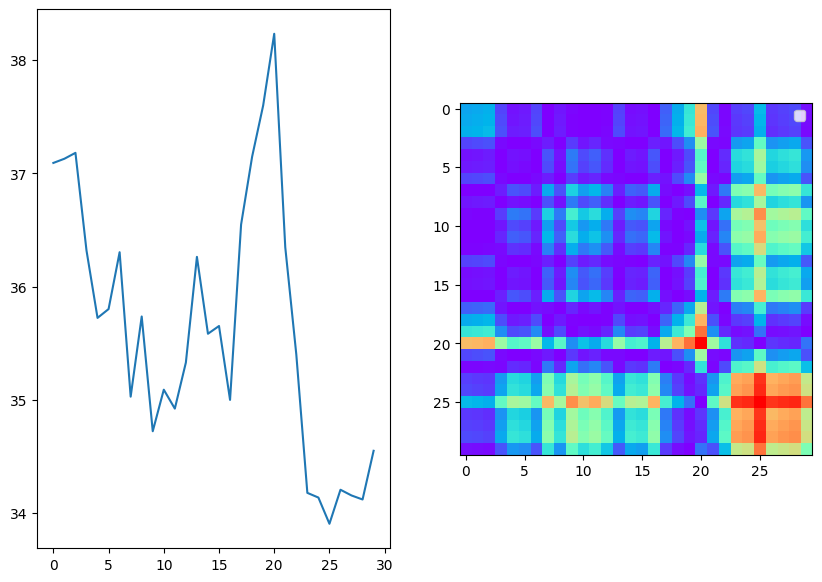

In [ ]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(orig_data[0, :])
ax[1].imshow(transformed_imgs[0], cmap="rainbow",label =y[0])
plt.legend()

In [ ]:
def get_cnn_model():
  model = Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  return model

In [ ]:
model = get_cnn_model()
orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(close)
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

history = model.fit(transformed_imgs, y_labels, epochs=10,  )

Epoch 1/10
60/60 [==============================] - 6s 75ms/step - loss: 5.6459 - accuracy: 0.6216
Epoch 2/10
60/60 [==============================] - 3s 45ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 3/10
60/60 [==============================] - 2s 35ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 4/10
60/60 [==============================] - 2s 36ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 5/10
60/60 [==============================] - 3s 57ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 6/10
60/60 [==============================] - 2s 35ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 7/10
60/60 [==============================] - 3s 57ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 8/10
60/60 [==============================] - 3s 55ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 9/10
60/60 [==============================] - 4s 73ms/step - loss: 5.6580 - accuracy: 0.6290
Epoch 10/10
60/60 [==============================] - 4s 58ms/step - loss: 5.6580 - accuracy: 0.6290


### b. Design CNN using Stationary version of  TS data


In [ ]:
model = get_cnn_model()
orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(diff_return[1:])
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

history = model.fit(transformed_imgs, y_labels, epochs=10,  )

Epoch 1/10
60/60 [==============================] - 3s 36ms/step - loss: 2.3083 - accuracy: 0.5108
Epoch 2/10
60/60 [==============================] - 2s 34ms/step - loss: 0.7085 - accuracy: 0.5066
Epoch 3/10
60/60 [==============================] - 2s 34ms/step - loss: 0.7157 - accuracy: 0.5108
Epoch 4/10
60/60 [==============================] - 3s 54ms/step - loss: 0.7115 - accuracy: 0.5103
Epoch 5/10
60/60 [==============================] - 4s 64ms/step - loss: 0.7151 - accuracy: 0.5029
Epoch 6/10
60/60 [==============================] - 3s 57ms/step - loss: 0.7048 - accuracy: 0.5235
Epoch 7/10
60/60 [==============================] - 2s 37ms/step - loss: 0.7013 - accuracy: 0.5516
Epoch 8/10
60/60 [==============================] - 5s 85ms/step - loss: 0.6807 - accuracy: 0.5680
Epoch 9/10
60/60 [==============================] - 4s 72ms/step - loss: 0.6741 - accuracy: 0.5859
Epoch 10/10
60/60 [==============================] - 3s 42ms/step - loss: 0.6631 - accuracy: 0.6166


### c. CNN using Fractional Diffferencing version of TS


In [ ]:
model = get_cnn_model()
orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(frac_diff_return)
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

history = model.fit(transformed_imgs, y_labels, epochs=10,  )

Epoch 1/10
53/53 [==============================] - 4s 63ms/step - loss: 6.9056 - accuracy: 0.5402
Epoch 2/10
53/53 [==============================] - 2s 35ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 3/10
53/53 [==============================] - 2s 35ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 4/10
53/53 [==============================] - 2s 35ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 5/10
53/53 [==============================] - 2s 35ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 6/10
53/53 [==============================] - 2s 35ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 7/10
53/53 [==============================] - 3s 54ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 8/10
53/53 [==============================] - 2s 44ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 9/10
53/53 [==============================] - 2s 36ms/step - loss: 7.0478 - accuracy: 0.5378
Epoch 10/10
53/53 [==============================] - 2s 35ms/step - loss: 7.0478 - accuracy: 0.5378


### d. CNN Model performance with different Data sets

Original data performance seems to be better. Need to check for any lookahead bias or other such design problesm. Also we can use hyper parameters optimization techniques to fine tune our models.

## Step 4 CNN vs MLP result Discussion